# Wisconsin Diagnostic Breast Cancer (WDBC)
### UC Irvine Machine Learning Repository

1. ID number
2. Diagnosis (M = malignant, B = benign)

3-32

Ten real-valued features are computed for each cell nucleus:

a. **Radius** (mean of distances from center to points on the perimeter)  
b. **Texture** (standard deviation of gray-scale values)  
c. **Perimeter**  
d. **Area**  
e. **Smoothness** (local variation in radius lengths)  
f. **Compactness** (perimeter² / area - 1.0)  
g. **Concavity** (severity of concave portions of the contour)  
h. **Concave points** (number of concave portions of the contour)  
i. **Symmetry**  
j. **Fractal dimension** ("coastline approximation" - 1)

https://pucrio.grupoa.education/plataforma/course/604904/content/17968468

https://pucrio.grupoa.education/plataforma/course/604904/content/17968468

In [1]:
# %pip install pandas
# %pip install scikit-learn
# %pip install numpy
# %pip install matplotlib

In [2]:
# Configuration to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


In [3]:
# FILE_PATH = 'wdbc.data'
URL = 'https://raw.githubusercontent.com/FernandoMiyazaki/puc-rio-mvp2-qualidade-seguranca-sistemas-inteligentes/main/api/machine_learning/notebooks/wdbc.data'
DELIMITER = ','
COLUMN_NAMES = [
    'id_number',
    'diagnosis',
    'radius_mean',
    'texture_mean',
    'perimeter_mean',
    'area_mean',
    'smoothness_mean',
    'compactness_mean',
    'concavity_mean',
    'concave_points_mean',
    'symmetry_mean',
    'fractal_dimension_mean',
    'radius_se',
    'texture_se',
    'perimeter_se',
    'area_se',
    'smoothness_se',
    'compactness_se',
    'concavity_se',
    'concave_points_se',
    'symmetry_se',
    'fractal_dimension_se',
    'radius_worst',
    'texture_worst',
    'perimeter_worst',
    'area_worst',
    'smoothness_worst',
    'compactness_worst',
    'concavity_worst',
    'concave_points_worst',
    'symmetry_worst',
    'fractal_dimension_worst'
]
# TEST_SIZE = 0.20
# SEED = 7
# SCORING = 'accuracy'
# NUM_PARTITIONS = 10

In [4]:
df = pd.read_csv(
    filepath_or_buffer=URL,
    delimiter=DELIMITER,
    names=COLUMN_NAMES,
    header=None
)

In [5]:
df.head()

,id_number,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_number                569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
# df['diagnosis'] = df.pop('diagnosis')

In [8]:
corr_matrix = df.corr()
diagnostic_corr = corr_matrix['diagnosis'].sort_values(ascending=False)
high_corr_features = diagnostic_corr[diagnostic_corr > 0.7]
df_filtered = df[high_corr_features.index]

In [9]:
df_filtered

,diagnosis,concave_points_worst,perimeter_worst,concave_points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean
0,1,0.2654,184.60,0.14710,25.380,122.80,2019.0,17.99,1001.0
1,1,0.1860,158.80,0.07017,24.990,132.90,1956.0,20.57,1326.0
2,1,0.2430,152.50,0.12790,23.570,130.00,1709.0,19.69,1203.0
3,1,0.2575,98.87,0.10520,14.910,77.58,567.7,11.42,386.1
4,1,0.1625,152.20,0.10430,22.540,135.10,1575.0,20.29,1297.0
...,...,...,...,...,...,...,...,...,...
564,1,0.2216,166.10,0.13890,25.450,142.00,2027.0,21.56,1479.0
565,1,0.1628,155.00,0.09791,23.690,131.20,1731.0,20.13,1261.0
566,1,0.1418,126.70,0.05302,18.980,108.30,1124.0,16.60,858.1
567,1,0.2650,184.60,0.15200,25.740,140.10,1821.0,20.60,1265.0


In [10]:
df_filtered['diagnosis'] = df_filtered.pop('diagnosis')

In [11]:
df_filtered

,concave_points_worst,perimeter_worst,concave_points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,diagnosis
0,0.2654,184.60,0.14710,25.380,122.80,2019.0,17.99,1001.0,1
1,0.1860,158.80,0.07017,24.990,132.90,1956.0,20.57,1326.0,1
2,0.2430,152.50,0.12790,23.570,130.00,1709.0,19.69,1203.0,1
3,0.2575,98.87,0.10520,14.910,77.58,567.7,11.42,386.1,1
4,0.1625,152.20,0.10430,22.540,135.10,1575.0,20.29,1297.0,1
...,...,...,...,...,...,...,...,...,...
564,0.2216,166.10,0.13890,25.450,142.00,2027.0,21.56,1479.0,1
565,0.1628,155.00,0.09791,23.690,131.20,1731.0,20.13,1261.0,1
566,0.1418,126.70,0.05302,18.980,108.30,1124.0,16.60,858.1,1
567,0.2650,184.60,0.15200,25.740,140.10,1821.0,20.60,1265.0,1


In [12]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_filtered.values
X = array[:,0:8]
y = array[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

KNN: 0.936377 (0.024666)
CART: 0.947391 (0.027746)
NB: 0.932077 (0.035390)
SVM: 0.927729 (0.036236)


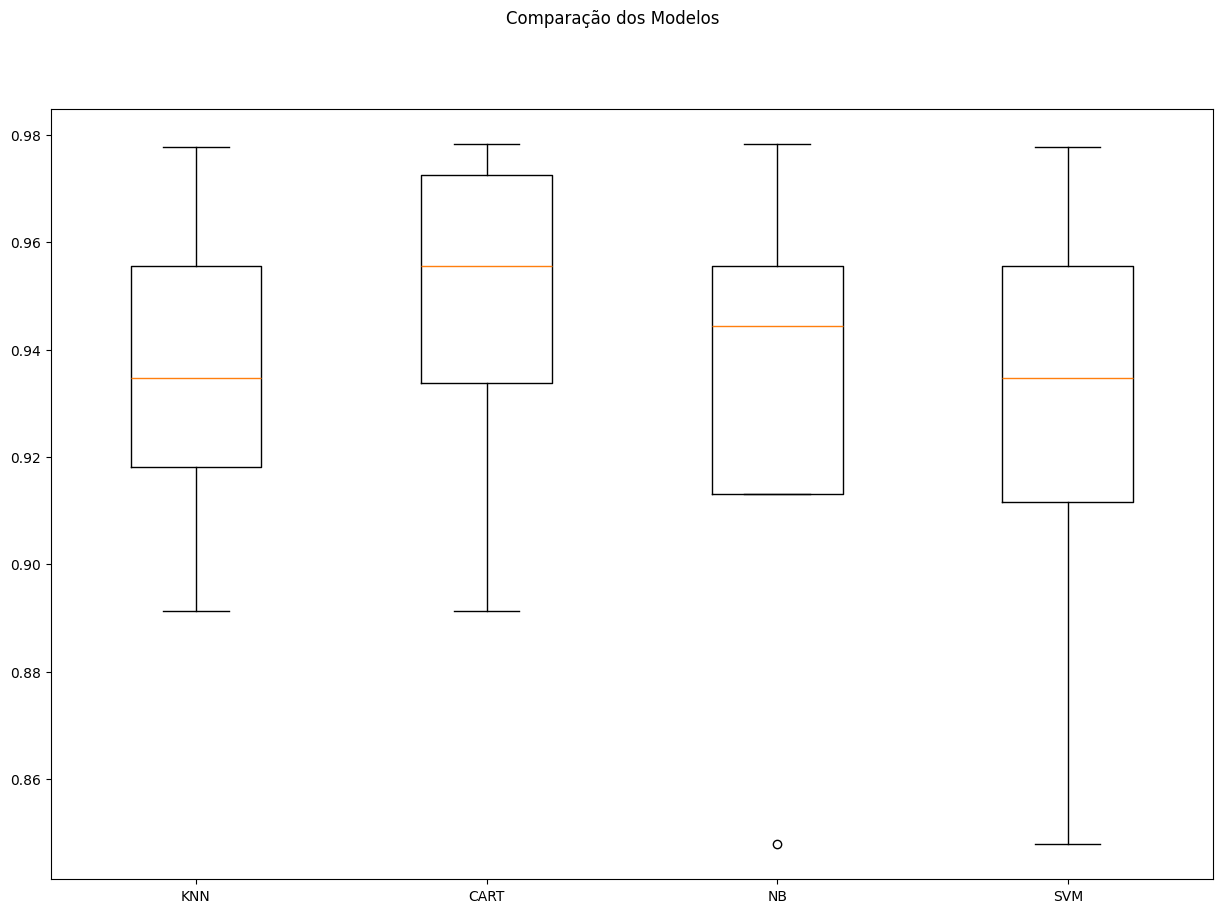

In [13]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Analisando os resultados, verificamos que, considerando a acurácia média, o modelo treinado com o CART atingiu os melhores resultados. Entretanto, vale executar um novo experimento com esses mesmos algoritmos mas utilizando uma versão do dataset padronizada e outra normalizada, comparando os resultados. Para essa tarefa, será utilizada a biblioteca Pipeline.

KNN-orig: 0.936 (0.025)
CART-orig: 0.947 (0.028)
NB-orig: 0.932 (0.035)
SVM-orig: 0.928 (0.036)
KNN-padr: 0.961 (0.032)
CART-padr: 0.943 (0.031)
NB-padr: 0.943 (0.032)
SVM-padr: 0.956 (0.041)
KNN-norm: 0.954 (0.036)
CART-norm: 0.947 (0.034)
NB-norm: 0.943 (0.032)
SVM-norm: 0.954 (0.043)


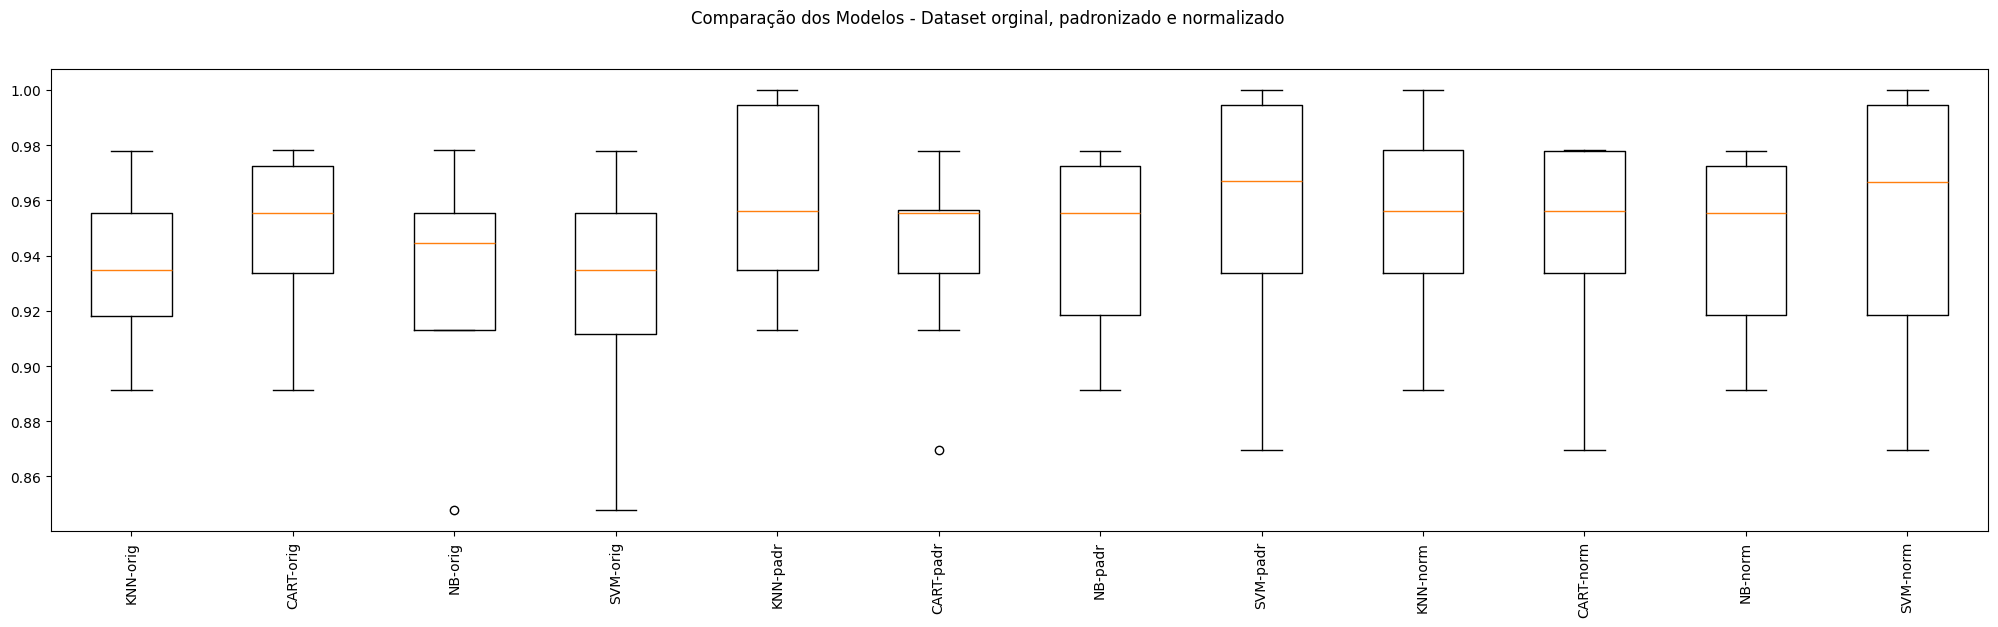

In [14]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Para o dataset original, verificou-se anteriormente que o modelo CART apresentou a melhor acurácia média. Entretanto, para os datasets padronizado e normalizado, o modelo que atingiu a melhor acurácia média foi o SVM (em ambos os casos). Considerando os datasets original, padronizado e normalizado, a acurácia mais alta (0,976) foi obtida com o modelo SVM no dataset normalizado.

Podemos tentar encontrar modelos ainda melhores fazendo a otimização de seus hiperparâmetros utilizando a biblioteca GridSearchCV.

In [15]:
np.random.seed(7)  # Definindo uma semente global

# Lista de modelos para otimização
models = [
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC())
]

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Parâmetros para GridSearchCV
param_grids = {
    'KNN': {
        'KNN__n_neighbors': [1, 3, 5, 7, 9, 11],
        'KNN__metric': ["euclidean", "manhattan", "minkowski"]
    },
    'CART': {
        'CART__max_depth': [None, 10, 20, 30],
        'CART__min_samples_split': [2, 5, 10],
        'CART__min_samples_leaf': [1, 2, 4]
    },
    'NB': {
        'NB__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
    },
    'SVM': {
        'SVM__C': [0.1, 1, 10, 100],
        'SVM__gamma': [1, 0.1, 0.01, 0.001],
        'SVM__kernel': ['rbf', 'linear']
    }
}

# Lista de pipelines
pipelines = []

# Criando pipelines para os modelos
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[min_max_scaler, (name, model)])))

# Parâmetros de cross-validation e scoring
scoring = 'accuracy'
kfold = 5

# Executando o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    if model_type in param_grids:
        param_grid = param_grids[model_type]
        grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold)
        grid.fit(X_train, y_train)
        # Imprimindo a melhor configuração
        print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))


Modelo: KNN-orig - Melhor: 0.940659 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Modelo: KNN-padr - Melhor: 0.964835 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 11}
Modelo: KNN-norm - Melhor: 0.960440 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3}
Modelo: CART-orig - Melhor: 0.947253 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 2}
Modelo: CART-padr - Melhor: 0.947253 usando {'CART__max_depth': 20, 'CART__min_samples_leaf': 2, 'CART__min_samples_split': 2}
Modelo: CART-norm - Melhor: 0.942857 usando {'CART__max_depth': None, 'CART__min_samples_leaf': 1, 'CART__min_samples_split': 5}
Modelo: NB-orig - Melhor: 0.929670 usando {'NB__var_smoothing': 1e-09}
Modelo: NB-padr - Melhor: 0.945055 usando {'NB__var_smoothing': 1e-09}
Modelo: NB-norm - Melhor: 0.945055 usando {'NB__var_smoothing': 1e-09}
Modelo: SVM-orig - Melhor: 0.949451 usando {'SVM__C': 1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Modelo: SVM-padr 

Modelo: SVM-padr - Melhor: 0.971429 usando {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}

In [16]:
np.random.seed(7)  # Setting the seed for reproducibility

# Standardization of the data
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(C=10, 
            gamma=1, 
            kernel='linear')
model.fit(rescaledX, y_train)

rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(f"Accuracy: {accuracy_score(y_test, predictions):.2f}")

Accuracy: 0.92


In [17]:
np.random.seed(7)

model = SVC(C=10, 
            gamma=1, 
            kernel='linear')

pipeline = Pipeline(steps=[('StandardScaler', StandardScaler()), ('SVC', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.9210526315789473


In [18]:
# Salvando o modelo
model_filename = 'svc_breast_cancer_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'standard_scaler_breast_cancer.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
    
# Salvando o pipeline
pipeline_filename = 'svc_breast_cancer_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)
    
# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=df_filtered.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[df_filtered.columns[-1]])
X_test_df.to_csv("../data/X_test_dataset_breast_cancer.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_breast_cancer.csv", index=False)